In [3]:
from dataset import *

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarn

KeyboardInterrupt: 

In [ ]:
units = get_units()

static_presentations = get_stimulus_presentations(stimulus_name="static_gratings")
static_spike_data = get_conditionwise_spike_statistics(stimulus_name="static_gratings")

drifting_presentations = get_stimulus_presentations(stimulus_name="drifting_gratings")
drifting_spike_data = get_conditionwise_spike_statistics(stimulus_name="drifting_gratings")

In [ ]:
static_spike_data = static_spike_data.reset_index("unit_id")
drifting_spike_data = drifting_spike_data.reset_index("unit_id")

KeyError: 'Requested level (unit_id) does not match index name (stimulus_condition_id)'

In [ ]:
# map orientation from stimulus presentations to spike data
static_presentations_unique = static_presentations.reset_index().set_index('stimulus_condition_id')
static_orientation_map = static_presentations_unique['orientation'].to_dict()

drifting_presentations_unique = drifting_presentations.reset_index().set_index('stimulus_condition_id')
drifting_orientations_map = drifting_presentations_unique['orientation'].to_dict()

NameError: name 'static_presentations' is not defined

In [ ]:
# add orientation to spike data
static_spike_data['orientation'] = static_spike_data.index.get_level_values('stimulus_condition_id').map(static_orientation_map)
drifting_spike_data['orientation'] = drifting_spike_data.index.get_level_values('stimulus_condition_id').map(drifting_orientations_map)

In [ ]:
static_spike_data['orientation'] = static_spike_data['orientation'].replace('null', np.nan)
drifting_spike_data['orientation'] = drifting_spike_data['orientation'].replace('null', np.nan)

static_spike_data_clean = static_spike_data.dropna(subset=['orientation'])
drifting_spike_data_clean = drifting_spike_data.dropna(subset=['orientation'])

In [ ]:
# Create tuning curves
static_tuning_curves = static_spike_data_clean.groupby(['unit_id', 'orientation']).spike_count.mean().unstack()
drifting_tuning_curves = drifting_spike_data_clean.groupby(['unit_id', 'orientation']).spike_count.mean().unstack()

Investigating and comparing the OSI values for units in static and drifting gratings.

In [ ]:
# Find preferred and orthogonal orientations
static_preferred_orientation = static_tuning_curves.idxmax(axis=1)
R_pref = static_tuning_curves.max(axis=1)
R_orth = static_tuning_curves.apply(lambda x: x[(x.idxmax() + 90) % 180], axis=1) 

# Calculate OSI
static_OSI = (R_pref - R_orth) / (R_pref + R_orth + 1e-6)  

print("Static OSI values:", static_OSI.sort_values(ascending=False).head())

Static OSI values: unit_id
951810647    0.835667
951810560    0.818086
951815212    0.800089
951819532    0.769541
951827457    0.757154
dtype: float64


In [ ]:
# Find preferred and orthogonal orientations
drifting_preferred_orientation = drifting_tuning_curves.idxmax(axis=1)
R_pref = drifting_tuning_curves.max(axis=1)
R_orth = drifting_tuning_curves.apply(lambda x: x[(x.idxmax() + 90) % 360], axis=1) 

# Calculate OSI
drifting_OSI = (R_pref - R_orth) / (R_pref + R_orth + 1e-6)  

print("Drifting OSI values:", drifting_OSI.sort_values(ascending=False).head())

Drifting OSI values: unit_id
951816866    1.000000
951815365    0.989341
951815212    0.988463
951815256    0.970007
951815237    0.963878
dtype: float64


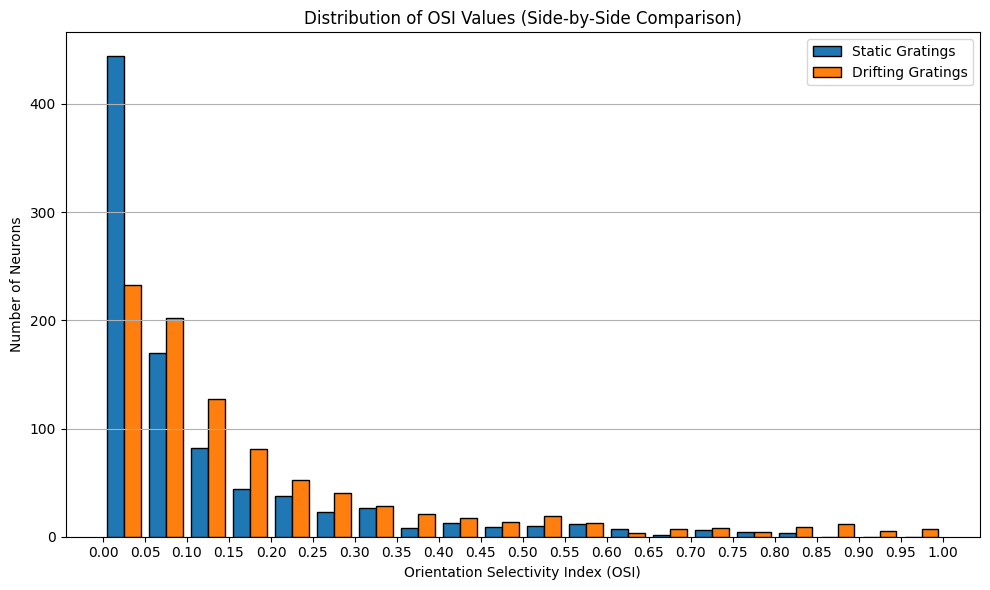

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(0, 1.05, 0.05)
bin_centers = (bins[:-1] + bins[1:]) / 2  # Middle of each bin

static_counts, _ = np.histogram(static_OSI, bins=bins)
drifting_counts, _ = np.histogram(drifting_OSI, bins=bins)

width = 0.02  # Smaller than 0.05 to fit side-by-side

plt.figure(figsize=(10,6))
plt.bar(bin_centers - width/2, static_counts, width=width, label='Static Gratings', align='center', edgecolor='black')
plt.bar(bin_centers + width/2, drifting_counts, width=width, label='Drifting Gratings', align='center', edgecolor='black')

plt.xlabel('Orientation Selectivity Index (OSI)')
plt.ylabel('Number of Neurons')
plt.title('Distribution of OSI Values (Side-by-Side Comparison)')
plt.xticks(bins)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()

In [ ]:
from scipy.stats import kurtosis, skew

static_skew = skew(static_OSI)
static_kurt = kurtosis(static_OSI)
drifting_skew = skew(drifting_OSI)
drifting_kurt = kurtosis(drifting_OSI)

print("=== OSI Distribution Shape Statistics ===\n")

print("Static Gratings:")
print(f"  Skewness : {static_skew:.3f}")
print(f"  Kurtosis : {static_kurt:.3f}\n")

print("Drifting Gratings:")
print(f"  Skewness : {drifting_skew:.3f}")
print(f"  Kurtosis : {drifting_kurt:.3f}")


=== OSI Distribution Shape Statistics ===

Static Gratings:
  Skewness : 2.258
  Kurtosis : 5.009

Drifting Gratings:
  Skewness : 1.937
  Kurtosis : 3.397


We can draw a number of conclusions from the distribution of OSI values for units between the two stimuli. 

1) As we would expect the distribution is highly non-normal. Only a few neurons have a high OSI and are responsible for interpreting orientation.
2) Drifting activates more neurons with high OSI overall.
3) Static distribution illicits a higher hurtosis indicating a narrower sharper peak and heavier tails than drifting. This suggests fewer relatively higher tuned neurons. This can probably be interpreted as the drifting nature of the grating is a kind of noise which triggers a greater response in neurons in general instead of a few concentrating on orientation only.

#### Investigating overlap in highly tuned neurons between static and drifting

ANOVA

In [ ]:
# Perform ANOVA for each unit for static presentations
static_p_values = static_spike_data_clean.groupby('unit_id').apply(
    lambda x: f_oneway(*[group.spike_count for name, group in x.groupby('orientation')])[1]
)

print(f"Number of units with significant orientation tuning (p<0.05) for static gratings: {(static_p_values < 0.05).sum()}")

Number of units with significant orientation tuning (p<0.05) for static gratings: 282


In [ ]:
# Perform ANOVA for each unit for drifting presentations
drifting_p_values = drifting_spike_data_clean.groupby('unit_id').apply(
    lambda x: f_oneway(*[group.spike_count for name, group in x.groupby('orientation')])[1]
)

print(f"Number of units with significant orientation tuning (p<0.05) for drifting gratings: {(drifting_p_values < 0.05).sum()}")

Number of units with significant orientation tuning (p<0.05) for drifting gratings: 257


In [ ]:
static_unit_regions = get_units()['ecephys_structure_acronym']

static_tuning_curves_with_regions = pd.merge(
    static_unit_regions.rename('ecephys_structure_acronym'),
    static_tuning_curves,          
    on="unit_id",        
    how="inner"       
)

drifting_unit_regions = get_units()['ecephys_structure_acronym']

drifting_tuning_curves_with_regions = pd.merge(
    drifting_unit_regions.rename('ecephys_structure_acronym'),
    drifting_tuning_curves,          
    on="unit_id",        
    how="inner"       
)

In [ ]:
# Select highly tuned neurons (high OSI and statistically significant)
static_filtered_neurons = static_OSI[(static_OSI > 0.5) & (static_p_values < 0.05)].index
static_selected_neurons = static_tuning_curves_with_regions.loc[static_filtered_neurons]
static_selected_neurons_list = static_selected_neurons.index.unique()

drifting_filtered_neurons = drifting_OSI[(drifting_OSI > 0.5) & (drifting_p_values < 0.05)].index
drifting_selected_neurons = drifting_tuning_curves_with_regions.loc[drifting_filtered_neurons]
drifting_selected_neurons_list = drifting_selected_neurons.index.unique()

In [ ]:
# 1. Compare number of highly tuned units
print("=== Highly Tuned Neurons Summary ===")
print(f"Static Gratings: {len(static_selected_neurons_list)} neurons selected (OSI > 0.5 and p < 0.05)")
print(f"Drifting Gratings: {len(drifting_selected_neurons_list)} neurons selected (OSI > 0.5 and p < 0.05)")
print()

=== Highly Tuned Neurons Summary ===
Static Gratings: 43 neurons selected (OSI > 0.5 and p < 0.05)
Drifting Gratings: 81 neurons selected (OSI > 0.5 and p < 0.05)



Almost twice as many highly tuned neurons for drifting compared to static gratings.

In [ ]:
# 2. Compare distribution across regions

# Count neurons per region
static_region_counts = static_selected_neurons['ecephys_structure_acronym'].value_counts().sort_index()
drifting_region_counts = drifting_selected_neurons['ecephys_structure_acronym'].value_counts().sort_index()

# Merge into a table
region_comparison = pd.DataFrame({
    'Static Gratings': static_region_counts,
    'Drifting Gratings': drifting_region_counts
}).fillna(0).astype(int)

print("=== Regional Distribution of Highly Tuned Neurons ===")
print(region_comparison)

=== Regional Distribution of Highly Tuned Neurons ===
       Static Gratings  Drifting Gratings
VISal               15                 28
VISam                6                 14
VISl                10                  9
VISp                 9                 19
VISpm                0                  1
VISrl                2                  9
grey                 1                  1


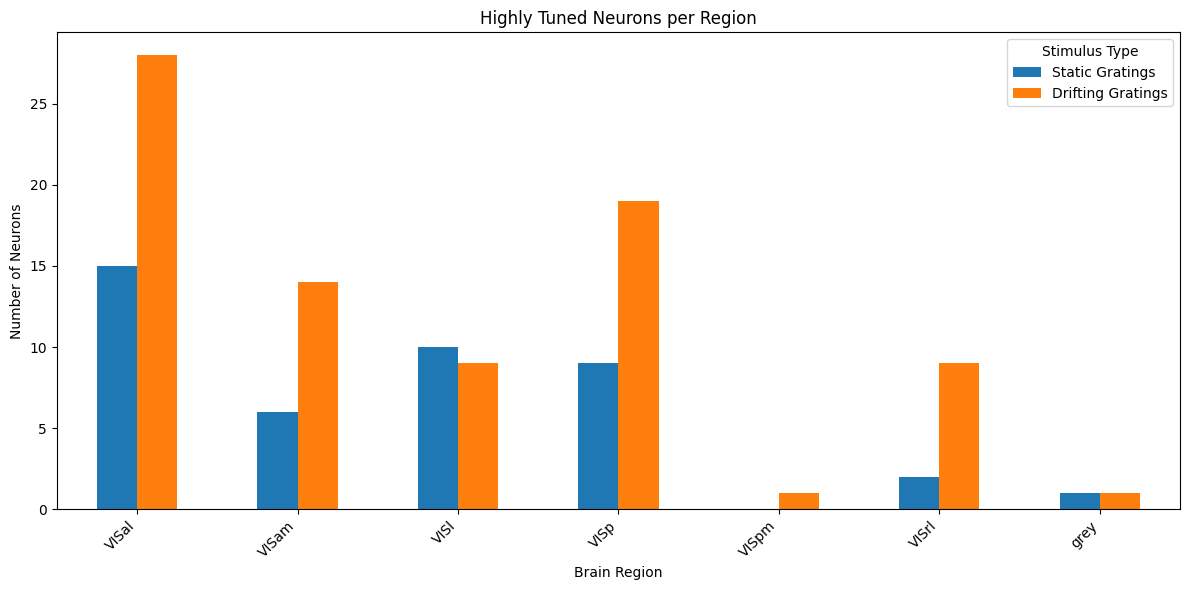

In [ ]:
region_comparison.plot(kind='bar', figsize=(12,6))
plt.title('Highly Tuned Neurons per Region')
plt.ylabel('Number of Neurons')
plt.xlabel('Brain Region')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stimulus Type')
plt.tight_layout()
plt.show()

Now we look into which highly tuned units overlap between static and drifting stimuli.

In [ ]:
# Find overlap
overlapping_units = static_selected_neurons_list.intersection(drifting_selected_neurons_list)

print(f"Number of highly tuned units in both static and drifting: {len(overlapping_units)}")

Number of highly tuned units in both static and drifting: 29


Given there are only 43 highly tuned units for static gratings this is well over half.

In [ ]:
# Build a DataFrame with the OSI values for overlapping units
overlap_osi = pd.DataFrame({
    "Static_OSI": static_OSI.loc[overlapping_units],
    "Drifting_OSI": drifting_OSI.loc[overlapping_units]
})

# Preview
print(overlap_osi.head())

           Static_OSI  Drifting_OSI
unit_id                            
951810560    0.818086      0.928451
951810647    0.835667      0.863997
951810885    0.584677      0.778598
951810947    0.591463      0.800895
951811267    0.644177      0.810765


Now we want to see if the same units are selective for the same orientation for both static and drifting. Sadly we can only look at 0 and 90 degrees as this is the only overlap.

In [ ]:
# Get preferred orientations for overlapping units
static_pref = static_tuning_curves.loc[overlapping_units].idxmax(axis=1)
drifting_pref = drifting_tuning_curves.loc[overlapping_units].idxmax(axis=1)

# Combine into a DataFrame
preferred_orientations = pd.DataFrame({
    "Static_Pref": static_pref,
    "Drifting_Pref": drifting_pref
})

# Focus only on 0 and 90 degrees for static preferred orientation
mask = preferred_orientations["Static_Pref"].isin([0, 90])

# Now, for those units, check if static and drifting preferred orientations are the same
same_pref = (preferred_orientations["Static_Pref"] == preferred_orientations["Drifting_Pref"])

# Apply the mask (only for units with static 0 or 90 degrees)
same_pref_masked = same_pref[mask]

# Calculate the percentage
percentage_same = same_pref_masked.mean() * 100

print(f"Percentage of overlapping units with same preferred orientation at 0 or 90 degrees: {percentage_same:.2f}%")


#### Maybe a bit more on comparing which ones overlap and compare with feature importance